# Exploitation of the data generated by the verifiers

In [38]:
from datasets import load_from_disk,Dataset
import pandas as pd
import seaborn as sb

ds_path =f"notebooks/verifier_execution/2025-11-03-14-ds_conc-p_full" 
full_ds = load_from_disk(ds_path)

### TP FP rates

In [39]:
def compute_tpfp(row):
    cl = "unassigned"
    expected = bool(row["expected"])
    classified = bool(row["classified"])
    if expected and classified:
        cl = "TP"
    if not expected and classified:
        cl = "FP"
    if expected and not classified:
        cl = "FN"
    if not expected and not classified:
        cl = "TN" 
    row["classification"] = cl
    
    return row

In [40]:

rates_ds = full_ds.map(compute_tpfp)
rates_df = rates_ds.to_pandas()
rates_df = rates_df[["approach_name","classification","id","try","index","classified","expected"]]

Map: 100%|██████████| 125/125 [00:00<00:00, 379.23 examples/s]


In [41]:
rates_df

,approach_name,classification,id,try,index,classified,expected
0,TextVerifier,TP,beam_coord_change,0,0,True,True
1,TextVerifier,FP,beam_coord_change,0,1,True,False
2,TextVerifier,FN,bee_eyes,0,2,False,True
3,TextVerifier,FP,bee_eyes,0,3,True,False
4,TextVerifier,FN,bee_longer_body,0,4,False,True
...,...,...,...,...,...,...,...
120,ClipSimVerifier,TP,cat_big,0,20,True,True
121,ClipSimVerifier,FP,cat_big,0,21,True,False
122,ClipSimVerifier,TP,cat_blue_nose,0,22,True,True
123,ClipSimVerifier,TP,cat_blue_nose,0,23,True,True


In [42]:
rates_agg_df = (
    rates_df.groupby(["index","approach_name"], as_index=False)
    .agg(lambda x: (
        "TP" if "TP" in x.values
        else "TN" if "TN" in x.values
        else x.iloc[0] if "FP" in x.values or "FN" in x.values
        else "classification_error"
    ) if x.name == "classification" else x.iloc[0])
)


Text(0.5, 0, '')

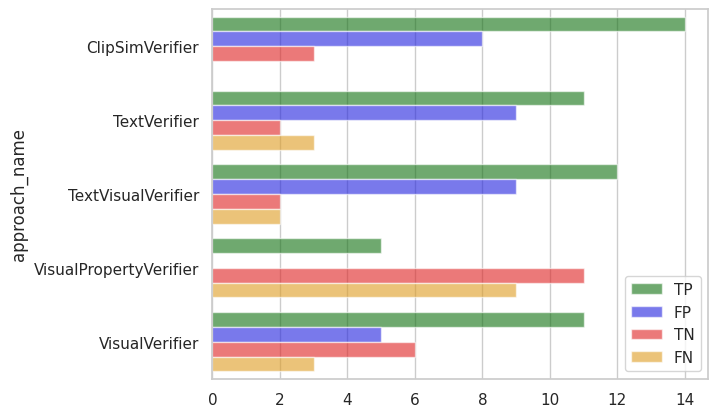

In [43]:
import seaborn as sns
import matplotlib.ticker as ticker

sns.set_theme(style="whitegrid")

g = sns.countplot(
    data=rates_agg_df,
    y="approach_name",
    hue="classification",
    palette=['green', 'blue', 'red','orange'],
    alpha=0.6,
    hue_order=["TP","FP","TN","FN"]
)
#todo change order and color of the labels to make it clearer

g.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
g.legend_.set_title(None)
g.set_xlabel("")


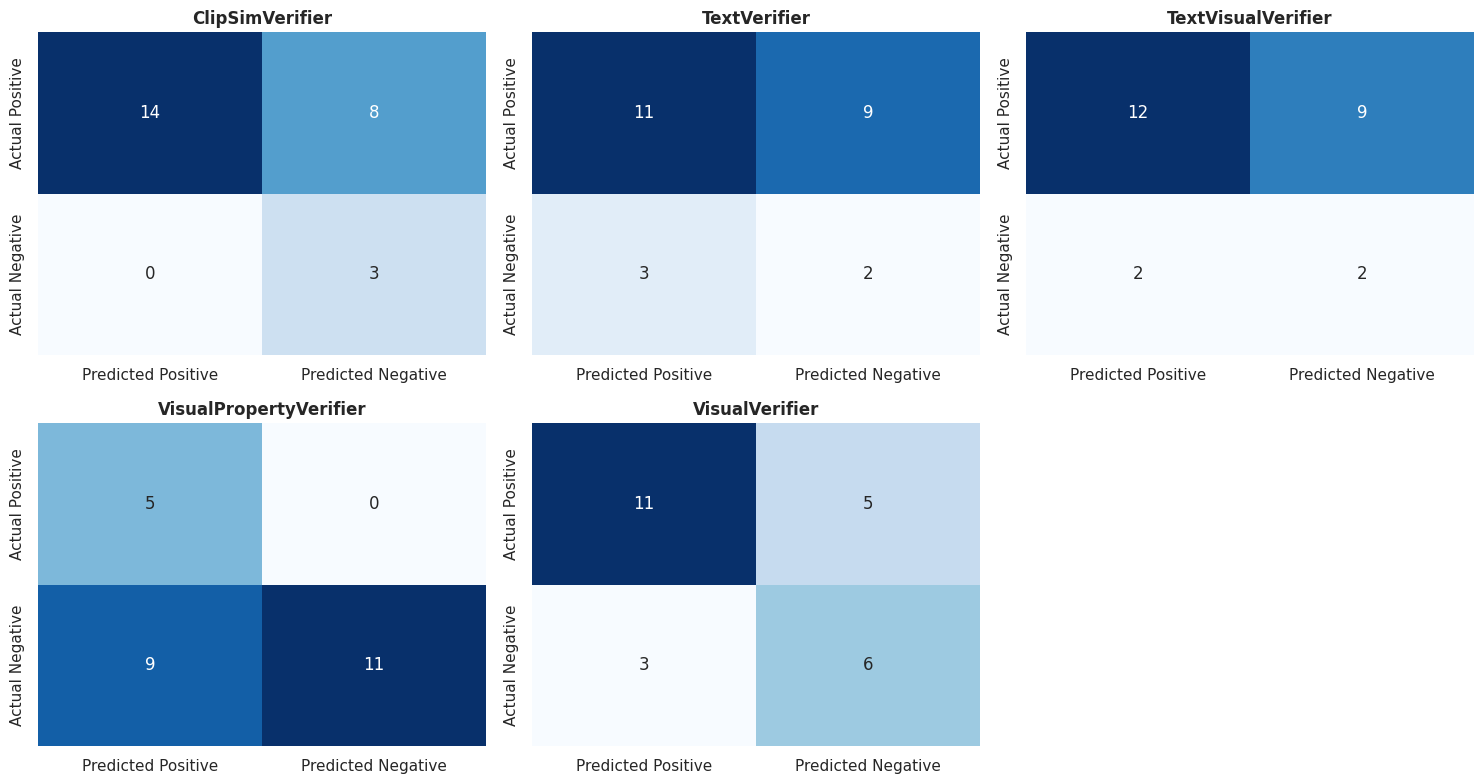

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sns.set_theme(style="whitegrid")

# Get unique approaches
approaches = rates_agg_df['approach_name'].unique()

# Calculate number of rows and columns for subplots
n_approaches = len(approaches)
n_cols = min(3, n_approaches)  # Max 3 columns
n_rows = int(np.ceil(n_approaches / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_approaches == 1:
    axes = np.array([axes])
axes = axes.flatten()

# Create confusion matrix for each approach
for idx, approach in enumerate(approaches):
    # Filter data for this approach
    approach_data = rates_agg_df[rates_agg_df['approach_name'] == approach]
    
    # Count occurrences of each classification
    counts = approach_data['classification'].value_counts()
    
    # Create 2x2 confusion matrix (Predicted vs Actual)
    matrix = np.array([
        [counts.get('TP', 0), counts.get('FP', 0)],
        [counts.get('FN', 0), counts.get('TN', 0)]
    ])
    
    # Plot heatmap
    sns.heatmap(
        matrix,
        annot=True,
        fmt='g',
        cmap='Blues',
        cbar=False,
        ax=axes[idx],
        xticklabels=['Predicted Positive', 'Predicted Negative'],
        yticklabels=['Actual Positive', 'Actual Negative']
    )
    
    axes[idx].set_title(f'{approach}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

# Hide empty subplots
for idx in range(n_approaches, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Precision and recall

In [45]:
import pandas as pd

def compute_metrics(group):
    TP = (group["classification"] == "TP").sum()
    FP = (group["classification"] == "FP").sum()
    FN = (group["classification"] == "FN").sum()
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return pd.Series({"precision": precision, "recall": recall, "f1": f1})

metrics_df = rates_agg_df.groupby("approach_name").apply(compute_metrics).reset_index()
metrics_df


/tmp/ipykernel_60132/830651736.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = rates_agg_df.groupby("approach_name").apply(compute_metrics).reset_index()


,approach_name,precision,recall,f1
0,ClipSimVerifier,0.636364,1.000000,0.777778
1,TextVerifier,0.550000,0.785714,0.647059
2,TextVisualVerifier,0.571429,0.857143,0.685714
3,VisualPropertyVerifier,1.000000,0.357143,0.526316
4,VisualVerifier,0.687500,0.785714,0.733333


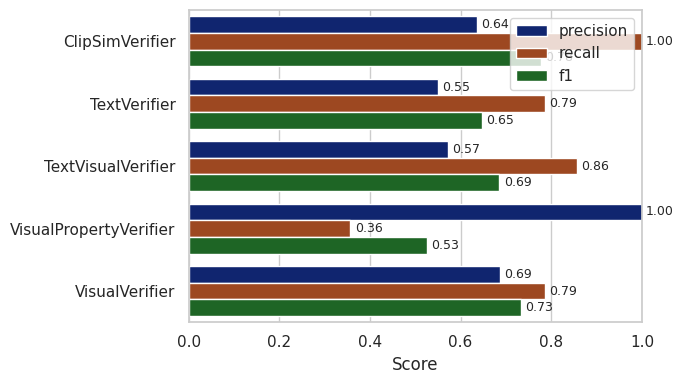

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics_melted = metrics_df.melt(id_vars="approach_name", var_name="metric", value_name="score")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 4))

g = sns.barplot(
    data=metrics_melted,
    y="approach_name",
    x="score",
    hue="metric",
    palette="dark",
    orient="h"
)

# Add value labels
for container in g.containers:
    g.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=9)

g.set_ylabel("")
g.set_xlabel("Score")
g.legend_.set_title("")
g.set_xlim(0, 1)

plt.tight_layout()
plt.show()


### Token usage

In [47]:
def compute_usage(row):
    match row["approach_name"]:
        case "TextVerifier" | "VisualVerifier" | "TextVisualVerifier":
            base_usage = row["usage_metadata"]["Base"][0]
            row["input_tokens"] = base_usage["prompt_tokens"]
            row["output_tokens"] = base_usage["completion_tokens"]
            row["total_tokens"] = base_usage["total_tokens"]
        case "VisualPropertyVerifier":
            propgen_usage = row["usage_metadata"]["property_gen"][0]
            propcheck_usage = row["usage_metadata"]["property_check"]
            row["input_tokens"] = propgen_usage["prompt_tokens"] + sum([tok_u["prompt_tokens"] for tok_u in propcheck_usage])
            row["output_tokens"] = propgen_usage["completion_tokens"]+sum([tok_u["completion_tokens"] for tok_u in propcheck_usage])
            row["total_tokens"] = propgen_usage["total_tokens"]+sum([tok_u["total_tokens"] for tok_u in propcheck_usage])
    return row

In [48]:

token_ds = full_ds.map(compute_usage)
token_df = token_ds.to_pandas()
token_df = token_df[["approach_name","id","total_tokens","output_tokens","input_tokens"]]

Map: 100%|██████████| 125/125 [00:00<00:00, 436.02 examples/s]


KeyError: 'input_tokens'

<Axes: ylabel='approach_name'>

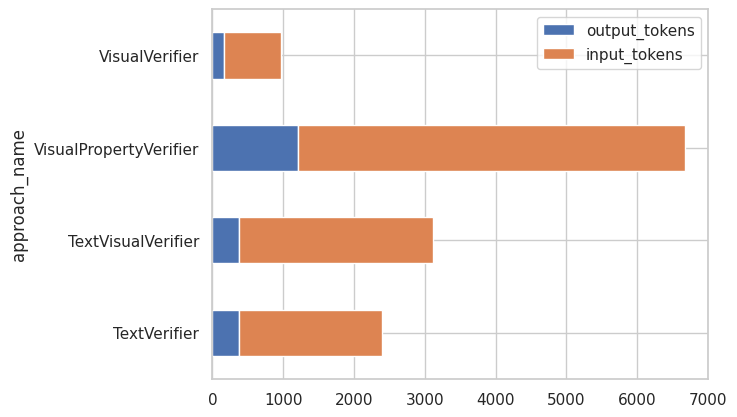

In [ ]:
avg_token_df = token_df[["approach_name","output_tokens","input_tokens"]].groupby("approach_name").mean().reset_index()
avg_token_df = avg_token_df.set_index("approach_name")
avg_token_df.plot(kind='barh',stacked=True)


### Error classifications

In [ ]:
err_df = full_ds.to_pandas()
